In [1]:
%matplotlib inline

import os
from scipy import ndimage as ndi, signal
from skimage import io, filters, exposure, color, img_as_float
import matplotlib.pylab as plt
import matplotlib
import numpy as np
from ipywidgets import interact, widgets, HBox
from IPython import display
import math
from random import randint

#Ajustar el tamaño de las imágenes:
matplotlib.rcParams['figure.figsize'] = (14,12)

In [2]:
def gaborFilter(x, y, orientation, bandwidth, deviationX, deviationY):
    orientationX = x*math.cos(orientation) - y*math.sin(orientation)
    orientationY = x*math.sin(orientation) - y*math.cos(orientation)
    
    firstTermX = orientationX * orientationX / deviationX
    firstTermY = orientationY * orientationY / deviationY
    firstTerm = math.exp ( -1/2 * (firstTermX + firstTermY) )
    secondTerm = math.cos(2 * math.pi * (1/bandwidth) * orientationX )
    
    return firstTerm * secondTerm;

gaborFilter(1, 3, math.pi / 4, 20, 10, 10)

0.7392457486079784

In [3]:
#x,y: es una coordenada en el filtro. Si definimos un filtro con radios rx, ry,
#entonces x ∈ [−rx,rx] e y ∈ [−ry,ry]. Recuerde, además, que el tamaño
#de un filtro gaussiano depende de su desviación estándar correspondiente.

def gabor_fn(theta, Lambda, sigma_x, sigma_y):

    # Bounding box
    nstds = 3 # Number of standard deviation sigma
    xmax = max(abs(nstds * sigma_x * np.cos(theta)), abs(nstds * sigma_y * np.sin(theta)))
    xmax = np.ceil(max(1, xmax))
    ymax = max(abs(nstds * sigma_x * np.sin(theta)), abs(nstds * sigma_y * np.cos(theta)))
    ymax = np.ceil(max(1, ymax))
    xmin = -xmax
    ymin = -ymax
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotation 
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta)
    return gb

In [4]:
gabor = gabor_fn(0, 10, 10, 10)

print(gabor.shape)
gabor


(61, 61)


array([[  1.23409804e-04,   1.65754961e-04,   2.20414653e-04, ...,
          2.20414653e-04,   1.65754961e-04,   1.23409804e-04],
       [  1.34098580e-04,   1.80111338e-04,   2.39505218e-04, ...,
          2.39505218e-04,   1.80111338e-04,   1.34098580e-04],
       [  6.81118735e-05,   9.14828527e-05,   1.21650424e-04, ...,
          1.21650424e-04,   9.14828527e-05,   6.81118735e-05],
       ..., 
       [  6.81118735e-05,   9.14828527e-05,   1.21650424e-04, ...,
          1.21650424e-04,   9.14828527e-05,   6.81118735e-05],
       [  1.34098580e-04,   1.80111338e-04,   2.39505218e-04, ...,
          2.39505218e-04,   1.80111338e-04,   1.34098580e-04],
       [  1.23409804e-04,   1.65754961e-04,   2.20414653e-04, ...,
          2.20414653e-04,   1.65754961e-04,   1.23409804e-04]])

In [5]:
def testGabor(theta = math.pi/4, Lambda = 30, sigma_x=40, sigma_y=40):
    gabor = gabor_fn(theta, Lambda, sigma_x, sigma_y)
    #fig, ax = plt.subplots()
    plt.imshow(gabor, cmap="binary")
    plt.show()
interact(testGabor, theta = (0, math.pi), Lambda = (0,100), sigma_x=(0,100), sigma_y=(0,100))

Widget Javascript not detected.  It may not be installed or enabled properly.


<function __main__.testGabor>

In [6]:
W = 4
for i in range(W*W):
    print(math.floor(i/W))

0
0
0
0
1
1
1
1
2
2
2
2
3
3
3
3


In [7]:
def createCellDemo(imageSize, cellSize):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellSize, cellSize, cellCount))
    print(cellCount)
    
createCellDemo(64,4) 

16


In [8]:
def createCellDemo(imageSize, cellSize):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellCount, cellCount)) 
    for j in range(imageSize):
        for i in range(imageSize):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = cellY * cellCount + cellX
            print("i:",i,"j:", j,"cellX:", cellX,"cellY:", cellY,"index:", cellIndex)
    
createCellDemo(16,4)

i: 0 j: 0 cellX: 0 cellY: 0 index: 0
i: 1 j: 0 cellX: 0 cellY: 0 index: 0
i: 2 j: 0 cellX: 0 cellY: 0 index: 0
i: 3 j: 0 cellX: 0 cellY: 0 index: 0
i: 4 j: 0 cellX: 1 cellY: 0 index: 1
i: 5 j: 0 cellX: 1 cellY: 0 index: 1
i: 6 j: 0 cellX: 1 cellY: 0 index: 1
i: 7 j: 0 cellX: 1 cellY: 0 index: 1
i: 8 j: 0 cellX: 2 cellY: 0 index: 2
i: 9 j: 0 cellX: 2 cellY: 0 index: 2
i: 10 j: 0 cellX: 2 cellY: 0 index: 2
i: 11 j: 0 cellX: 2 cellY: 0 index: 2
i: 12 j: 0 cellX: 3 cellY: 0 index: 3
i: 13 j: 0 cellX: 3 cellY: 0 index: 3
i: 14 j: 0 cellX: 3 cellY: 0 index: 3
i: 15 j: 0 cellX: 3 cellY: 0 index: 3
i: 0 j: 1 cellX: 0 cellY: 0 index: 0
i: 1 j: 1 cellX: 0 cellY: 0 index: 0
i: 2 j: 1 cellX: 0 cellY: 0 index: 0
i: 3 j: 1 cellX: 0 cellY: 0 index: 0
i: 4 j: 1 cellX: 1 cellY: 0 index: 1
i: 5 j: 1 cellX: 1 cellY: 0 index: 1
i: 6 j: 1 cellX: 1 cellY: 0 index: 1
i: 7 j: 1 cellX: 1 cellY: 0 index: 1
i: 8 j: 1 cellX: 2 cellY: 0 index: 2
i: 9 j: 1 cellX: 2 cellY: 0 index: 2
i: 10 j: 1 cellX: 2 cellY: 0 ind

i: 0 j: 15 cellX: 0 cellY: 3 index: 12
i: 1 j: 15 cellX: 0 cellY: 3 index: 12
i: 2 j: 15 cellX: 0 cellY: 3 index: 12
i: 3 j: 15 cellX: 0 cellY: 3 index: 12
i: 4 j: 15 cellX: 1 cellY: 3 index: 13
i: 5 j: 15 cellX: 1 cellY: 3 index: 13
i: 6 j: 15 cellX: 1 cellY: 3 index: 13
i: 7 j: 15 cellX: 1 cellY: 3 index: 13
i: 8 j: 15 cellX: 2 cellY: 3 index: 14
i: 9 j: 15 cellX: 2 cellY: 3 index: 14
i: 10 j: 15 cellX: 2 cellY: 3 index: 14
i: 11 j: 15 cellX: 2 cellY: 3 index: 14
i: 12 j: 15 cellX: 3 cellY: 3 index: 15
i: 13 j: 15 cellX: 3 cellY: 3 index: 15
i: 14 j: 15 cellX: 3 cellY: 3 index: 15
i: 15 j: 15 cellX: 3 cellY: 3 index: 15


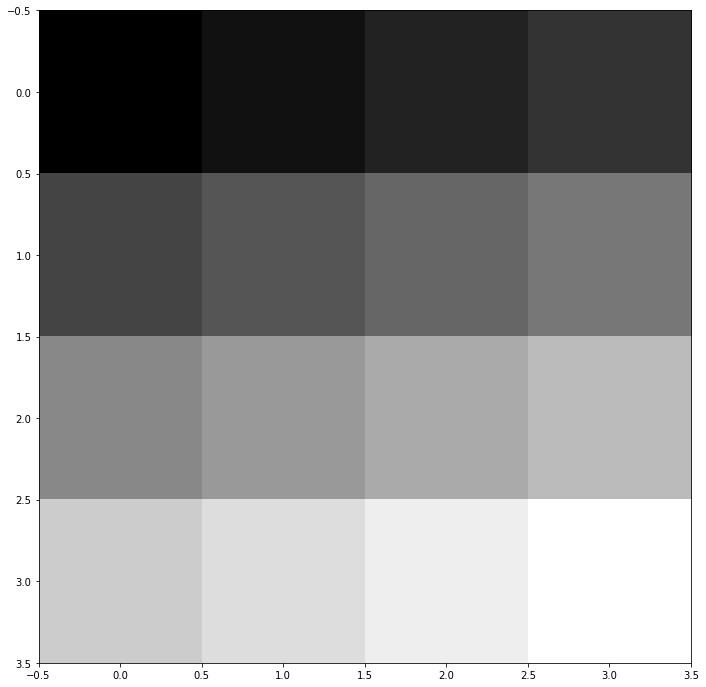

In [9]:
def createCellDemo(imageSize, cellSize):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellCount, cellCount)) 
    for j in range(imageSize):
        for i in range(imageSize):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = cellX * cellCount + cellY
            
            cellPixels[cellX, cellY] = cellIndex
    
    
    plt.imshow(cellPixels, cmap="gray")
        
createCellDemo(16,4)

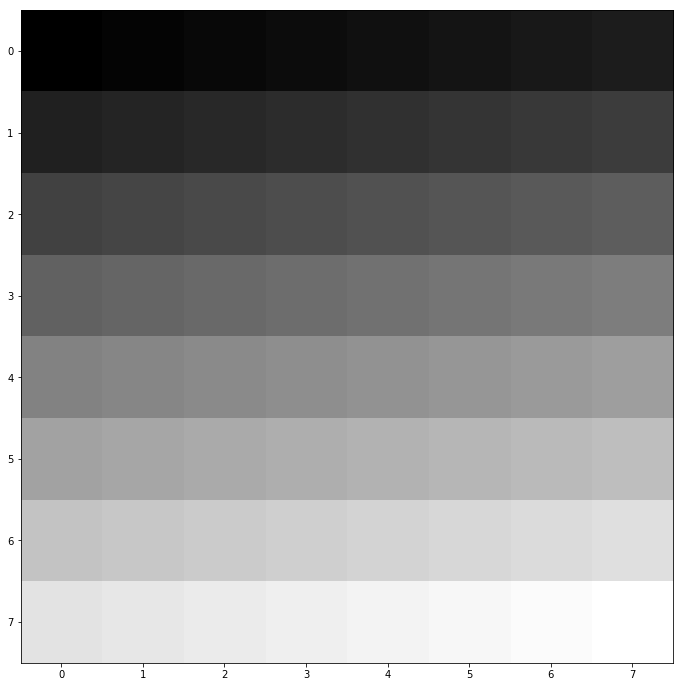

In [10]:
createCellDemo(32,4)

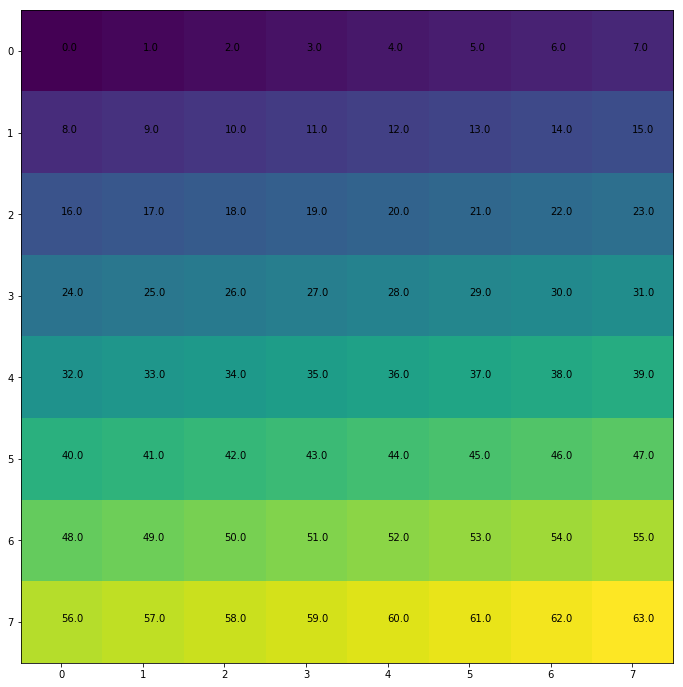

In [11]:
def createCellDemo(imageSize, cellSize):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellCount, cellCount)) 
    for j in range(imageSize):
        for i in range(imageSize):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = cellX * cellCount + cellY
            
            cellPixels[cellX, cellY] = cellIndex
    
    
    fig, ax = plt.subplots()
    ax.imshow(cellPixels)
    
    for j in range(cellPixels.shape[1]):
        for i in range(cellPixels.shape[0]):
            ax.annotate(cellPixels[i,j], (j,i))
        
createCellDemo(32,4)

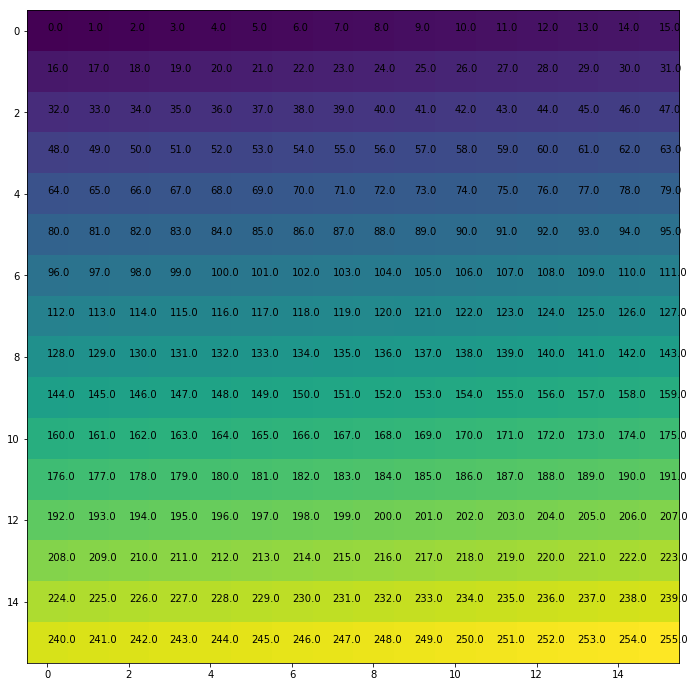

In [12]:
createCellDemo(64,4)

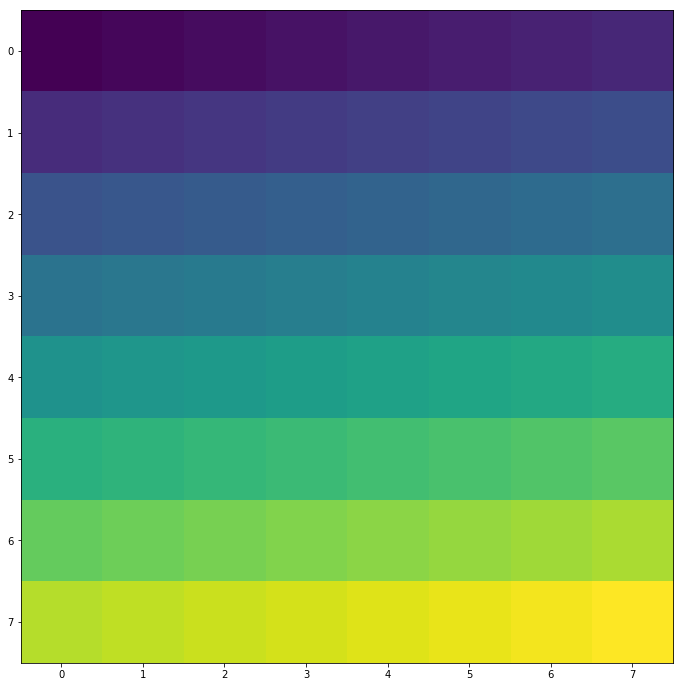

In [13]:
def decorateCells(ax, cellPixels, cellContent = None):
    if cellContent == "index":
        for j in range(cellPixels.shape[1]):
            for i in range(cellPixels.shape[0]):
                ax.annotate(cellPixels[i,j], (j,i))
                
    return ax, cellPixels

def createCellDemo(imageSize, cellSize, cellContent = None):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cellPixels = np.zeros((cellCount, cellCount)) 
    for j in range(imageSize):
        for i in range(imageSize):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = cellX * cellCount + cellY
            
            if cellContent == "index" or cellContent == None:
                cellPixels[cellX, cellY] = cellIndex
    
    fig, ax = plt.subplots()
    ax, cellPixels = decorateCells(ax, cellPixels, cellContent)
    ax.imshow(cellPixels)
    
createCellDemo(32,4)

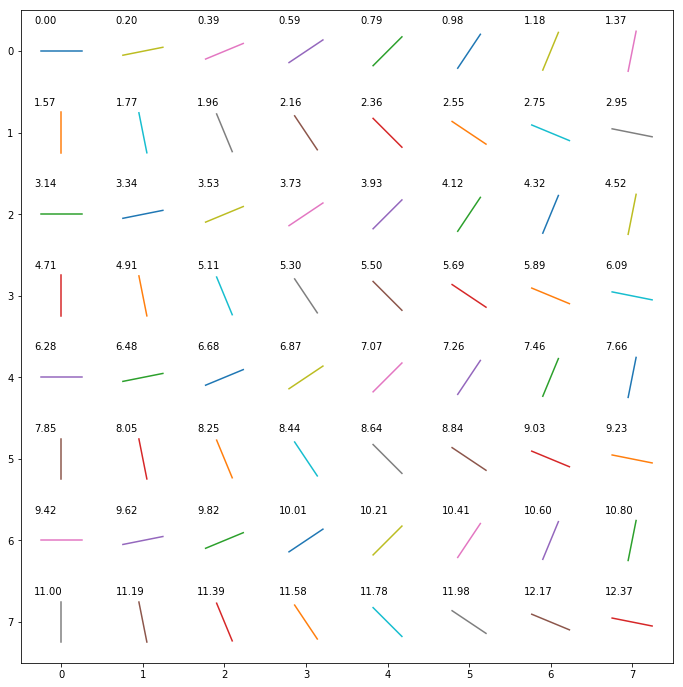

In [14]:
def decorateCells(fig, ax, cells, cellContent = None):
    if cellContent == "index":
        for j in range(cells.shape[1]):
            for i in range(cells.shape[0]):
                ax.annotate(cells[i,j], (j,i))
                
    if cellContent == "orientations":
        for j in range(cells.shape[1]):
            for i in range(cells.shape[0]):
                ax.plot([j-math.cos(cells[i,j])/4,j+math.cos(cells[i,j])/4],[i+math.sin(cells[i,j])/4,i-math.sin(cells[i,j])/4])
                ax.annotate('{:1.2f}'.format(cells[i,j]), (j-1/3,i-1/3))
                cells[i,j] = 0;

    return fig, ax, cells

def createCellDemo(imageSize, cellSize, cellContent = None):
    cellImage = np.zeros((imageSize, imageSize))
    cellCount = math.floor(imageSize/cellSize)
    cells = np.zeros((cellCount, cellCount)) 
    for j in range(imageSize):
        for i in range(imageSize):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            cellIndex = cellX * cellCount + cellY
            
            if cellContent == "index" or cellContent == None:
                cells[cellX, cellY] = cellIndex
            elif cellContent == "orientations":
                cells[cellX, cellY] = math.pi*cellIndex/cellCount/2
                
    fig, ax = plt.subplots()
    fig, ax, cells = decorateCells(fig, ax, cells, cellContent)
    ax.imshow(cells, cmap="binary")
    
createCellDemo(32,4, "orientations")

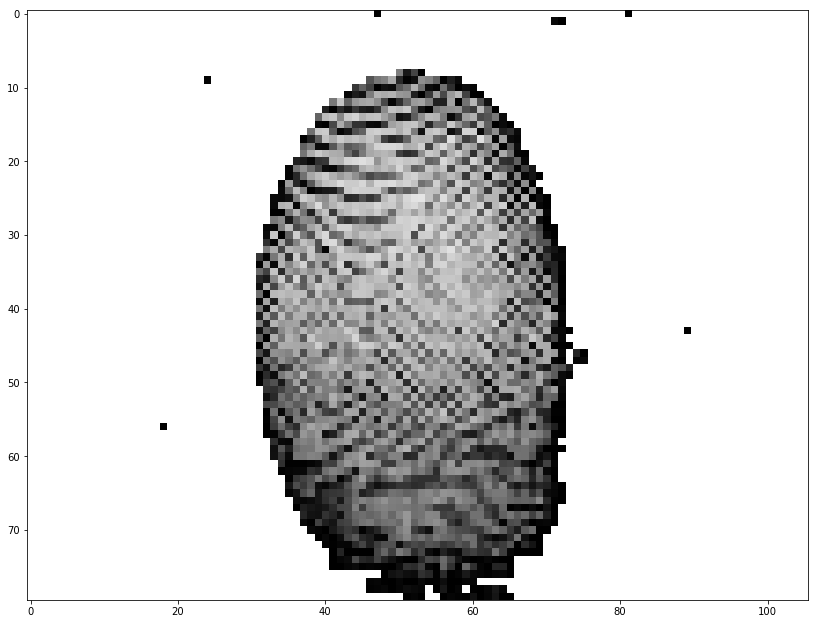

In [15]:
def imageOrientation(image, cellSize):
    rows, cols = image.shape
    cellRows = math.floor(rows/cellSize)
    cellCols = math.floor(cols/cellSize)
    cellCount = cellRows*cellCols
    cells = np.zeros((cellRows, cellCols)) 
    
    for j in range(cols):
        for i in range(rows):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            pixelValue = image[i,j]
            if(pixelValue<255):
                cells[cellX, cellY] = pixelValue
            
    fig, ax = plt.subplots()
    ax.imshow(cells, cmap="binary")

image = io.imread("./DB1_B/101_2.tif")
imageOrientation(image, 6)            

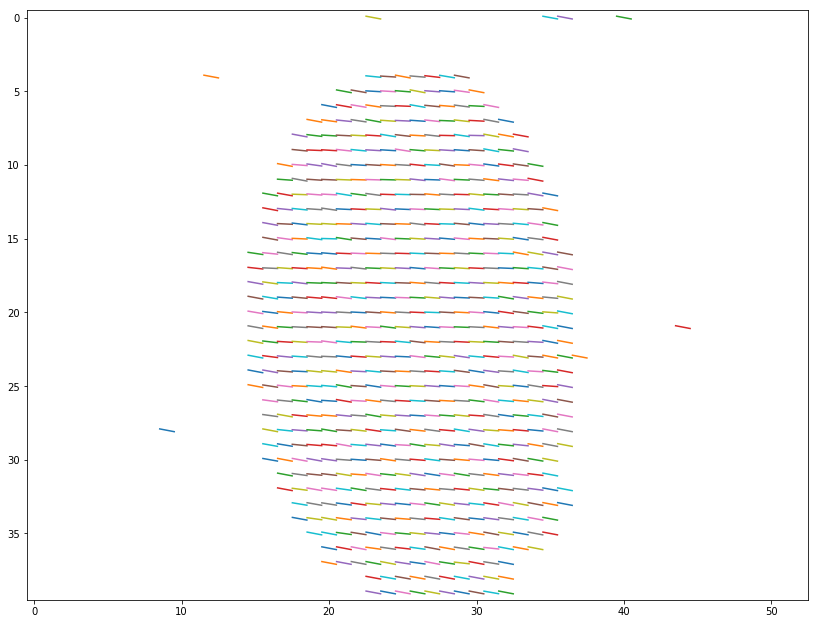

In [16]:
def imageOrientation(image, cellSize):
    rows, cols = image.shape
    cellRows = math.floor(rows/cellSize)
    cellCols = math.floor(cols/cellSize)
    cellCount = cellRows*cellCols
    cells = np.zeros((cellRows, cellCols)) 
    
    for j in range(cols):
        for i in range(rows):
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            pixelValue = image[i,j]
            if(pixelValue<255):
                cells[cellX, cellY] = 0.5 * math.pi * pixelValue / cellCount
            
    fig, ax = plt.subplots()
    for j in range(cellCols):
        for i in range(cellRows):
            if(cells[i,j]>0):
                ax.plot([j-math.cos(cells[i,j])/2,j+math.cos(cells[i,j])/2],[i-math.sin(cells[i,j])/2,i+math.sin(cells[i,j])/2])
            cells[i,j] = 0;
                
    ax.imshow(cells, cmap="binary")

imageFile = "./DB1_B/101_2.tif"
image = io.imread(imageFile)
imageOrientation(image, 12)    

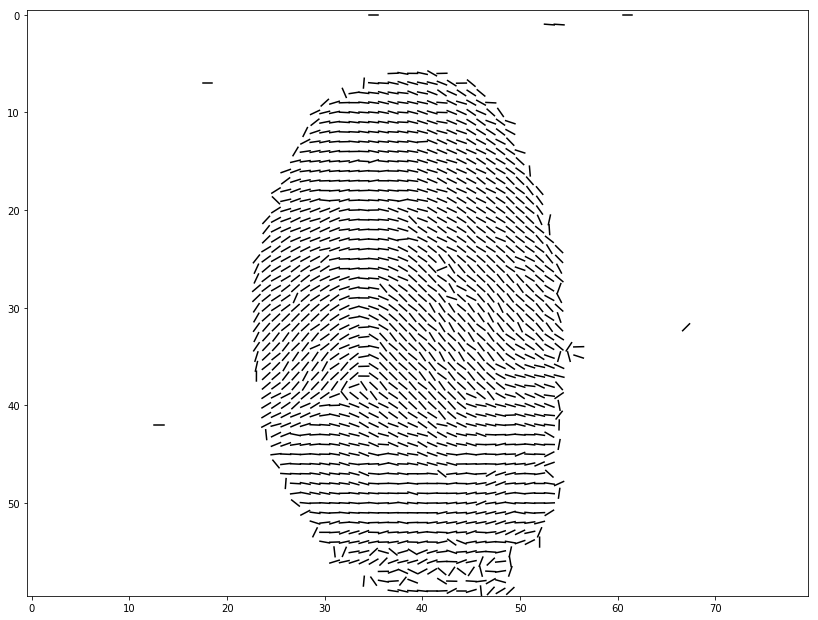

In [17]:
def imageOrientation(image, cellSize):
    rows, cols = image.shape
    cellRows = math.floor(rows/cellSize)
    cellCols = math.floor(cols/cellSize)
    cellCount = cellRows*cellCols

    sobelH = filters.sobel_h(image)
    sobelV = filters.sobel_v(image)
    
    cells = np.zeros((cellRows, cellCols)) 
    m_sines = np.zeros((cellRows, cellCols)) 
    m_cosines = np.zeros((cellRows, cellCols)) 
    
    for j in range(cols):
        for i in range(rows):
            if(image[i,j] == 255):
                continue
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            gx = sobelH[i,j]
            gy = sobelV[i,j]
            alfa = math.atan2(gy, gx)
            mag = math.sqrt(gx * gx + gy * gy)
            m_sines[cellX, cellY] = m_sines[cellX, cellY] + 2 * math.cos(alfa) * math.sin(alfa) * mag
            m_cosines[cellX, cellY] = m_cosines[cellX, cellY] + (math.cos(alfa) * math.cos(alfa) - math.sin(alfa) * math.sin(alfa)) * mag
            cellValue = math.pi + 0.5*math.atan2(m_sines[cellX, cellY], m_cosines[cellX, cellY])
            cells[cellX, cellY] = cellValue
            
    fig, ax = plt.subplots()
    for j in range(cellCols):
        for i in range(cellRows):
            if(cells[i,j]> 0):
                ax.plot([j - 0.5 * math.cos(cells[i,j]), j + 0.5 * math.cos(cells[i,j])],[i + 0.5 * math.sin(cells[i,j]), i - 0.5 * math.sin(cells[i,j])], color="black")
            cells[i,j] = 0;
                
    ax.imshow(cells, cmap="binary")

imageFile = "./DB1_B/101_2.tif"
image = io.imread(imageFile)
imageOrientation(image, 8)   

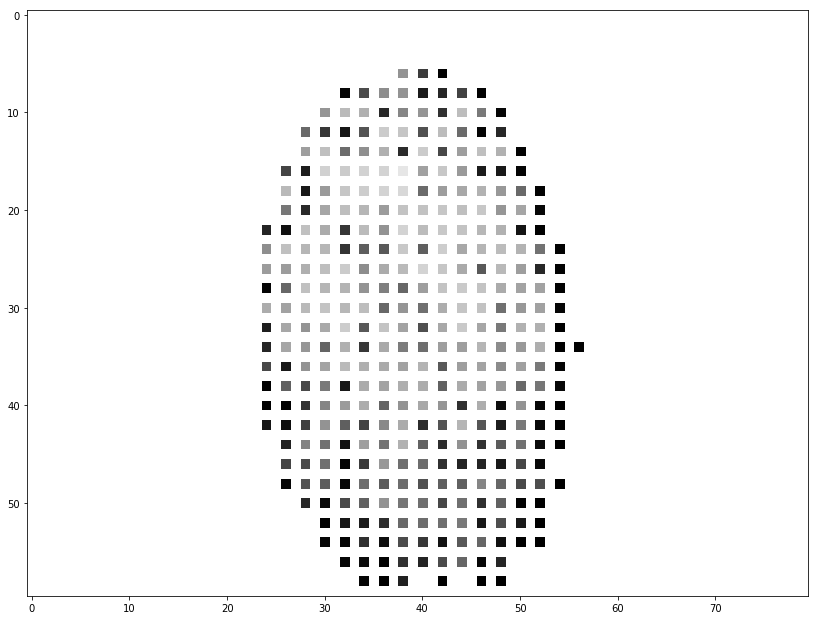

In [ ]:
def segmentImagen(image, cellSize):
    rows, cols = image.shape
    cellRows = math.floor(rows/cellSize)
    cellCols = math.floor(cols/cellSize)
    cellCount = cellRows*cellCols
    cells = np.zeros((cellRows, cellCols)) 
    
    for j in range(cols):
        for i in range(rows):
            if(image[i,j] == 255):
                continue
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            if(cellX % 2==0 and cellY % 2 ==0):
                cells[cellX, cellY] = image[i,j]
    
    fig, ax = plt.subplots()
    ax.imshow(cells, cmap="binary")
    
imageFile = "./DB1_B/101_2.tif"
image = io.imread(imageFile)
segmentImagen(image, 8)      

In [ ]:
def imageOrientation(image, cellSize):
    """Mostrar Imagen original"""
    fig, ax = plt.subplots()
    ax.imshow(image, cmap="gray")
    
    """Init"""
    rows, cols = image.shape
    cellRows = math.floor(rows/cellSize)
    cellCols = math.floor(cols/cellSize)
    cellCount = cellRows*cellCols
    
    cells = np.zeros((cellRows, cellCols)) 
    m_sines = np.zeros((cellRows, cellCols)) 
    m_cosines = np.zeros((cellRows, cellCols)) 
    
    """Calcular orientaciones"""
    sobelH = filters.sobel_h(image)
    sobelV = filters.sobel_v(image)
    
    for j in range(cols):
        for i in range(rows):
            if(image[i,j] == 255):
                continue
            cellX = math.floor(i/cellSize)
            cellY = math.floor(j/cellSize)
            gx = sobelH[i,j]
            gy = sobelV[i,j]
            alfa = math.atan2(gy, gx)
            mag = math.sqrt(gx * gx + gy * gy)
            m_sines[cellX, cellY] = m_sines[cellX, cellY] + 2 * math.cos(alfa) * math.sin(alfa) * mag
            m_cosines[cellX, cellY] = m_cosines[cellX, cellY] + (math.cos(alfa) * math.cos(alfa) - math.sin(alfa) * math.sin(alfa)) * mag
            cellValue = math.pi + 0.5 * math.atan2(m_sines[cellX, cellY], m_cosines[cellX, cellY])
            cells[cellX, cellY] = cellValue
    
    """Mostrar orientaciones"""
    fig, ax = plt.subplots()
    arrowCells = np.zeros_like(cells)
    for j in range(cellCols):
        for i in range(cellRows):
            if(cells[i,j]> 0):
                ax.plot([j - 0.5 * math.cos(cells[i,j]), j + 0.5 * math.cos(cells[i,j])],[i + 0.5 * math.sin(cells[i,j]), i - 0.5 * math.sin(cells[i,j])], color="black")
                
    ax.imshow(arrowCells, cmap="binary")
    
    """Mejorar imagen"""
    improvedImage = np.zeros((rows, cols))
    
    for j in range(cellCols):
        for i in range(cellRows):
            orientation = cells[i, j]
            filtered = signal.correlate2d(image[i * cellSize: i * cellSize + cellSize, j * cellSize: j * cellSize + cellSize], gabor_fn(orientation, 10, 10, 10), mode="same")
            improvedImage[i * cellSize: i * cellSize + cellSize, j * cellSize: j * cellSize + cellSize] = filtered
                
    fig, ax = plt.subplots()
    ax.imshow(improvedImage, cmap="gray")
    
imageFile = "./DB1_B/101_2.tif"
image = io.imread(imageFile)
imageOrientation(image, 2)   